In [9]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dim_tienda = pd.read_csv('DIM_TIENDA.csv')
dim_tienda

,TIENDA_ID,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET
0,126,1,BC,Hogar,127.42,13,7,25.69107,-100.21261,Hogar Reunión,UT_DENSIDAD,TRAIN
1,681,1,C,Hogar,128.13,13,0,25.73571,-100.18086,Hogar Reunión,UT_DENSIDAD,TRAIN
2,117,1,C,Base,87.62,11,11,25.71883,-100.19133,Hogar Reunión,UT_DENSIDAD,TRAIN
3,682,1,C,Hogar,90.70,13,0,25.66952,-100.20744,Hogar Reunión,UT_DENSIDAD,TRAIN
4,275,1,C,Hogar,95.30,13,6,25.73766,-100.16116,Hogar Reunión,UT_DENSIDAD,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...
946,572,6,C,Hogar,0.00,13,0,25.57330,-100.02196,Hogar Reunión,UT_DENSIDAD,TRAIN
947,492,6,B,Base,0.00,13,0,25.27251,-100.00065,Hogar Reunión,UT_TRAFICO_VEHICULAR,TRAIN
948,172,6,CD,Receso,122.70,8,0,25.19135,-99.81539,Parada Técnica,UT_CARRETERA_GAS,TRAIN
949,748,6,C,Receso,0.00,0,0,25.27433,-100.01648,Parada Técnica,UT_CARRETERA_GAS,TRAIN


In [3]:
"""
LIMPIAR DATOS QUE TENEMOS
ELIMINAR REGISTROS CON COORDENADAS INVALIDAS (0,0)
CONVERTIR `PLAZA_CVE` y `TIENDA_ID` a categorica (string)
Las variables MTS2VENTAS_NUM, PUERTASREFRIG_NUM, CAJONESESTACIONAMIENTO_NUM tienen valores de 0 (que son incorrectos, no hacen sentido)
   - Hay que encontrar la manera de corregir estos datos erroneos (opciones, media, moda, llenar en base a las otras dos)

AGREGAR VARIABLES NUEVAS
- Numero de estblecimientos dentro de radio (SUPER, ABARROTES, OTROS OXXOS)
- Limpiar datos de ventas
- Métrica para determinar si es bueno o malo

"""

'\nLIMPIAR DATOS QUE TENEMOS\nELIMINAR REGISTROS CON COORDENADAS INVALIDAS (0,0)\nCONVERTIR `PLAZA_CVE` y `TIENDA_ID` a categorica (string)\nLas variables MTS2VENTAS_NUM, PUERTASREFRIG_NUM, CAJONESESTACIONAMIENTO_NUM tienen valores de 0 (que son incorrectos, no hacen sentido)\n   - Hay que encontrar la manera de corregir estos datos erroneos (opciones, media, moda, llenar en base a las otras dos)\n\nAGREGAR VARIABLES NUEVAS\n- Numero de estblecimientos dentro de radio (SUPER, ABARROTES, OTROS OXXOS)\n- Limpiar datos de ventas\n- Métrica para determinar si es bueno o malo\n\n'

In [4]:
dim_tienda['TIENDA_ID'] = dim_tienda['TIENDA_ID'].astype(str)
dim_tienda['PLAZA_CVE'] = dim_tienda['PLAZA_CVE'].astype(str)

## CORRECIÓN REFRIS, M2 Y ESTACIONAMIENTO

In [5]:
df_espacio = dim_tienda[['TIENDA_ID', 'MTS2VENTAS_NUM', 'PUERTASREFRIG_NUM', 'CAJONESESTACIONAMIENTO_NUM']]
df_espacio

,TIENDA_ID,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM
0,126,127.42,13,7
1,681,128.13,13,0
2,117,87.62,11,11
3,682,90.70,13,0
4,275,95.30,13,6
...,...,...,...,...
946,572,0.00,13,0
947,492,0.00,13,0
948,172,122.70,8,0
949,748,0.00,0,0


In [6]:
import pandas as pd

# Crear una copia binaria para agrupar
df_espacio_bin = df_espacio.copy()
df_espacio_bin['MTS2VENTAS_BIN'] = (df_espacio['MTS2VENTAS_NUM'] > 0).astype(int)
df_espacio_bin['PUERTASREFRIG_BIN'] = (df_espacio['PUERTASREFRIG_NUM'] > 0).astype(int)
df_espacio_bin['CAJONES_BIN'] = (df_espacio['CAJONESESTACIONAMIENTO_NUM'] > 0).astype(int)

# Agrupar por combinaciones
conteo_combinaciones = df_espacio_bin.groupby(['MTS2VENTAS_BIN', 'PUERTASREFRIG_BIN', 'CAJONES_BIN']).size().reset_index(name='conteo')
conteo_combinaciones = conteo_combinaciones.sort_values(by='conteo', ascending=False)

conteo_combinaciones


,MTS2VENTAS_BIN,PUERTASREFRIG_BIN,CAJONES_BIN,conteo
5,1,1,1,414
4,1,1,0,237
0,0,0,0,164
1,0,1,0,103
3,1,0,1,20
2,1,0,0,13


In [14]:
# Filtrar registros donde CAJONESESTACIONAMIENTO_NUM == 0 y las otras variables > 0
filtro = (
    (df_espacio['CAJONESESTACIONAMIENTO_NUM'] == 0) &
    (df_espacio['MTS2VENTAS_NUM'] > 0) &
    (df_espacio['PUERTASREFRIG_NUM'] > 0)
)
df_espacio[filtro]

,TIENDA_ID,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM
1,681,128.13,13,0
3,682,90.70,13,0
5,684,116.07,13,0
6,694,78.48,13,0
8,702,73.24,13,0
...,...,...,...,...
936,192,93.17,10,0
937,189,86.11,7,0
938,187,98.70,9,0
941,183,164.00,10,0


# VENTAS

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore


In [13]:
ventas = pd.read_csv('Venta.csv')
ventas

,TIENDA_ID,MES_ID,VENTA_TOTAL
0,813,202404,1042761.16
1,742,202404,604946.96
2,436,202404,2486787.81
3,732,202404,680701.78
4,282,202404,1227768.82
...,...,...,...
21376,885,202312,1157010.83
21377,793,202401,699916.91
21378,53,202401,1008108.28
21379,960,202401,1324156.07


In [15]:
id = 310
ventas_tienda = ventas[ventas.TIENDA_ID == id]
df = ventas_tienda.sort_values(by='MES_ID')
serie = df['VENTA_TOTAL']
df

,TIENDA_ID,MES_ID,VENTA_TOTAL
17926,310,202301,1425348.04
7274,310,202302,1069267.79
8892,310,202303,1412554.04
15412,310,202304,1528722.88
18176,310,202305,1509959.73
7628,310,202306,1549424.25
19743,310,202307,1594409.11
16986,310,202308,1644395.81
6404,310,202309,1454349.64
15779,310,202310,1250759.84


id = 1
ventas_tienda = ventas[ventas.TIENDA_ID == id]
df = ventas_tienda.sort_values(by='MES_ID')
serie = df['VENTA_TOTAL']

# Calcular z-score y detectar solo outliers bajos
z_scores = zscore(serie)
outliers_bajos = z_scores < -2

# Interpolación lineal solo en los outliers bajos
serie_suavizada = serie.copy()
serie_suavizada[outliers_bajos] = np.nan
serie_suavizada = serie_suavizada.interpolate(method='linear')

plt.figure(figsize=(12, 6))
plt.plot(df['MES_ID'], serie, marker='o', label='Serie original')
plt.plot(df['MES_ID'], serie_suavizada, marker='o', label='Serie suavizada', linestyle='--')
plt.xlabel('MES_ID')
plt.ylabel('VENTA_TOTAL')
plt.title(f'Tienda {id}: Serie original vs Serie suavizada')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:


# Suponiendo que `serie` es un pd.Series indexado por fecha
stl = STL(serie, seasonal=13)  # seasonal=periodo (ej. 12 para mensual, 7 para semanal)
resultado = stl.fit()

# Serie sin estacionalidad
serie_deseasonalizada = serie - resultado.seasonal

In [108]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from statsmodels.tsa.seasonal import STL

In [ ]:

# Asumimos que tu DataFrame se llama `ventas` y tiene columnas TIENDA_ID, MES_ID, VENTA_TOTAL

def corregir_y_promediar(df):
    df = df.sort_values(by='MES_ID')
    serie = df['VENTA_TOTAL']
    
    # Calcular z-score y detectar solo outliers bajos
    z_scores = zscore(serie)
    outliers_bajos = z_scores < -2

    # Interpolación lineal solo en los outliers bajos
    serie_suavizada = serie.copy()
    serie_suavizada[outliers_bajos] = np.nan
    serie_suavizada = serie_suavizada.interpolate(method='linear')


    # Calcular el promedio corregido
    promedio = serie_suavizada.mean()
    return promedio

# Aplicar por cada TIENDA_ID
tabla_promedios = (
    ventas.groupby('TIENDA_ID')
          .apply(corregir_y_promediar)
          .reset_index(name='PROMEDIO_CORREGIDO')
)

ValueError: Unable to determine period from endog

In [94]:
ventas.groupby('TIENDA_ID').mean()

,MES_ID,VENTA_TOTAL
TIENDA_ID,,
1,202349.0,7.080276e+05
2,202349.0,8.994741e+05
3,202349.0,8.274871e+05
4,202349.0,1.247370e+06
5,202349.0,1.596267e+06
...,...,...
1052,202349.0,1.136733e+06
1053,202349.0,7.660571e+05
1054,202349.0,1.561485e+06


In [98]:
promedios_reales = (
    ventas.groupby('TIENDA_ID')
          .mean()
          .rename(columns={'VENTA_TOTAL': 'PROMEDIO_CORREGIDO'})
)

promedios_reales

,MES_ID,PROMEDIO_CORREGIDO
TIENDA_ID,,
1,202349.0,7.080276e+05
2,202349.0,8.994741e+05
3,202349.0,8.274871e+05
4,202349.0,1.247370e+06
5,202349.0,1.596267e+06
...,...,...
1052,202349.0,1.136733e+06
1053,202349.0,7.660571e+05
1054,202349.0,1.561485e+06


In [70]:
tabla_promedios

,TIENDA_ID,PROMEDIO_CORREGIDO
0,1,7.297753e+05
1,2,9.245567e+05
2,3,8.534496e+05
3,4,1.285761e+06
4,5,1.634231e+06
...,...,...
1048,1052,1.164587e+06
1049,1053,7.958973e+05
1050,1054,1.597820e+06
1051,1055,1.040426e+06


In [73]:
ventas_esperadas = pd.read_csv("ventas_esperadas_train_test.csv")
ventas_esperadas

,TIENDA_ID,Venta esperada,DATASET
0,1,490000,TRAIN
1,2,490000,TRAIN
2,3,490000,TRAIN
3,4,490000,TRAIN
4,5,490000,TRAIN
...,...,...,...
1051,1052,480000,TRAIN
1052,1053,490000,TRAIN
1053,1054,490000,TRAIN
1054,1055,490000,TRAIN


In [102]:
# Unir tabla_promedios y ventas_esperadas sobre TIENDA_ID
df_join = tabla_promedios.merge(ventas_esperadas, on='TIENDA_ID', how='inner')
df_join['PORCENTAJE_CUMPLIMIENTO'] = df_join['PROMEDIO_CORREGIDO'] / df_join['Venta esperada']
df_join


,TIENDA_ID,PROMEDIO_CORREGIDO,Venta esperada,DATASET,PORCENTAJE_CUMPLIMIENTO
0,1,7.297753e+05,490000,TRAIN,1.489337
1,2,9.245567e+05,490000,TRAIN,1.886850
2,3,8.534496e+05,490000,TRAIN,1.741734
3,4,1.285761e+06,490000,TRAIN,2.624002
4,5,1.634231e+06,490000,TRAIN,3.335165
...,...,...,...,...,...
1048,1052,1.164587e+06,480000,TRAIN,2.426222
1049,1053,7.958973e+05,490000,TRAIN,1.624280
1050,1054,1.597820e+06,490000,TRAIN,3.260858
1051,1055,1.040426e+06,490000,TRAIN,2.123319


In [103]:
total = len(df_join)
mayores_a_1 = (df_join['PORCENTAJE_CUMPLIMIENTO'] > 1).sum()
menores_a_1 = (df_join['PORCENTAJE_CUMPLIMIENTO'] < 1).sum()

print(f"Mayores a 1: {mayores_a_1} ({mayores_a_1/total:.2%})")
print(f"Menores a 1: {menores_a_1} ({menores_a_1/total:.2%})")

Mayores a 1: 1013 (96.20%)
Menores a 1: 40 (3.80%)


In [104]:
rango_0_1 = ((df_join['PORCENTAJE_CUMPLIMIENTO'] >= 0) & (df_join['PORCENTAJE_CUMPLIMIENTO'] < 1)).sum()
rango_1_13 = ((df_join['PORCENTAJE_CUMPLIMIENTO'] >= 1) & (df_join['PORCENTAJE_CUMPLIMIENTO'] < 1.3)).sum()
rango_13_16 = ((df_join['PORCENTAJE_CUMPLIMIENTO'] >= 1.3) & (df_join['PORCENTAJE_CUMPLIMIENTO'] < 1.6)).sum()
rango_16_2 = ((df_join['PORCENTAJE_CUMPLIMIENTO'] >= 1.6) & (df_join['PORCENTAJE_CUMPLIMIENTO'] < 2)).sum()

rango_2_mas = (df_join['PORCENTAJE_CUMPLIMIENTO'] >= 2).sum()

print(f"De 0 a 1: {rango_0_1} ({rango_0_1/total:.2%})")
print(f"De 1 a 1.3: {rango_1_13} ({rango_1_13/total:.2%})")
print(f"De 1.3 a 1.6: {rango_13_16} ({rango_13_16/total:.2%})")
print(f"De 1.6 a 2: {rango_16_2} ({rango_16_2/total:.2%})")
print(f"De 2 o más: {rango_2_mas} ({rango_2_mas/total:.2%})")

De 0 a 1: 40 (3.80%)
De 1 a 1.3: 82 (7.79%)
De 1.3 a 1.6: 142 (13.49%)
De 1.6 a 2: 209 (19.85%)
De 2 o más: 580 (55.08%)


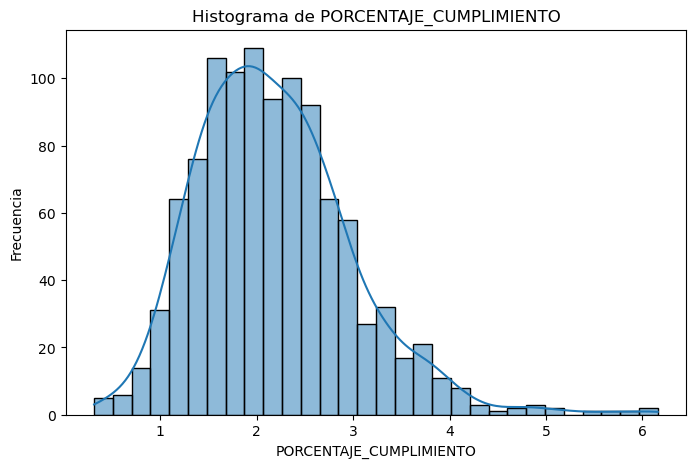

In [89]:
plt.figure(figsize=(8, 5))
sns.histplot(df_join['PORCENTAJE_CUMPLIMIENTO'], bins=30, kde=True)
plt.title('Histograma de PORCENTAJE_CUMPLIMIENTO')
plt.xlabel('PORCENTAJE_CUMPLIMIENTO')
plt.ylabel('Frecuencia')
plt.show()

In [84]:
# Calcular la diferencia de porcentaje de cumplimiento entre TEST y TRAIN
df_join_train = df_join[df_join['DATASET'] == 'TRAIN']
df_join_test = df_join[df_join['DATASET'] == 'TEST']

media_train = df_join_train['PORCENTAJE_CUMPLIMIENTO'].mean()
media_test = df_join_test['PORCENTAJE_CUMPLIMIENTO'].mean()

print(f"Media TRAIN: {media_train:.2f}")
print(f"Media TEST: {media_test:.2f}")
print(f"Diferencia (TEST - TRAIN): {media_test - media_train:.2f}")

Media TRAIN: 2.18
Media TEST: 2.24
Diferencia (TEST - TRAIN): 0.06
